In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import pandas as pd
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pytorch_lightning as pl

import opf
import opf.utils
import opf.dataset
import utils
import yaml
from glob import glob

# fix issues with figures using underscores in their names
mpl.rcParams["text.usetex"] = False


In [3]:
run_id = "447df0095d924a2591563368bd088ee8"
GUILD_HOME = "/home/damow/.pyenv/versions/3.9.6/envs/opf/.guild"
run_dir = f"{GUILD_HOME}/runs/{run_id}/tensorboard/{run_id}"

In [4]:
api = wandb.Api()
run = api.run(f"damowerko/opf/{run_id}")

run.config.update(data_dir="../data")
dm = opf.dataset.CaseDataModule(**run.config)
barrier = utils.create_model(dm, run.config).cpu()

# load checkpoint
checkpoints = glob(f"{run_dir}/*.ckpt")
checkpoint = torch.load(checkpoints[0], map_location="cpu")
barrier.load_state_dict(checkpoint["state_dict"], strict=True)

save_dir = f"../figures/{run.config['case_name']}/"
os.makedirs(save_dir, exist_ok=True)
def save(title: str, fig=plt):
    fig.savefig(save_dir + f"{title}.png")
    fig.savefig(save_dir + f"{title}.pdf")

# barrier = opf.utils.create_model(dm, run.config)
# utils.load_checkpoint(barrier, run.id, run_dir)
print(run.config)

{'F': 32, 'K': 8, 'L': 2, 's': 10, 't': 500, 'lr': 0.0003, 'eps': 0.0001, 'log': 1, 'gpus': 1, 'wandb': 1, 'log_dir': '.', 'readout': 'local', 'data_dir': '../data', 'hotstart': 'None', 'patience': 400, 'root_dir': '/home/damow/repos/OPF/scripts/./', 'case_name': 'case118', 'activation': 'leaky_relu', 'batch_size': 256, 'max_epochs': 2000, 'cost_weight': 0.01, 'fast_dev_run': False, 'adj_threshold': 0.01, 'gradient_clip_val': 0, 'constraint_features': 1, 'enforce_constraints': 1}


In [5]:
barrier.detailed_metrics = True
outputs = utils.test(barrier, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/damow/.pyenv/versions/3.9.6/envs/opf/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1303: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

In [27]:
df = outputs.copy()
(df[["test/cost","test/inequality/rate"]].mean(),
df[[
    "test/equality/error_max",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]].mean())

(test/cost               903.958189
 test/inequality/rate      0.001496
 dtype: float64,
 test/equality/error_max                               0.000000
 test/inequality/error_max                             0.042751
 test/inequality/active_power/error_max                0.038636
 test/inequality/reactive_power/error_max              0.000000
 test/inequality/voltage_magnitude/error_max           0.007118
 test/inequality/forward_rate/error_max                0.000000
 test/inequality/backward_rate/error_max               0.000000
 test/inequality/voltage_angle_difference/error_max    0.000000
 dtype: float64)

# Statistics

In [7]:
print(f"""
Mean violation rate: {df["test/inequality/rate"].max()}
Rate of any violation: {(df["test/inequality/rate"] > 1e-8).sum() / len(df)}
GNN Cost: {df["test/cost"].mean()}
IPOPT Cost: {df["acopf/cost"].mean()}
""")


Mean violation rate: 0.03049645390070922
Rate of any violation: 0.825
GNN Cost: 903.9581889534818
IPOPT Cost: 836.1014911699283



# Histograms

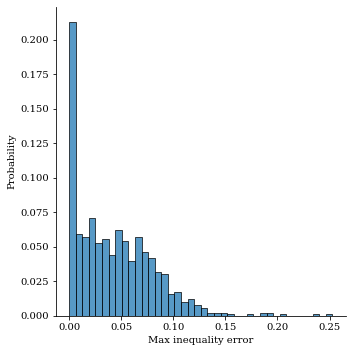

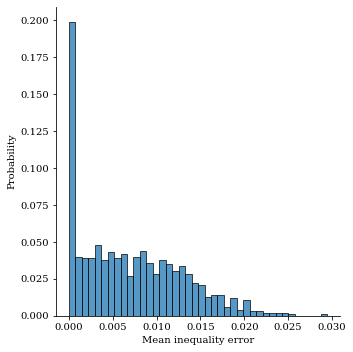

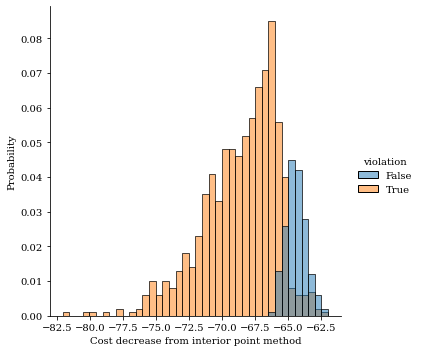

In [8]:
bins = 40

sns.displot(df, x="test/inequality/error_max", stat="probability", bins=bins)
plt.xlabel("Max inequality error")
save("error_max")

sns.displot(df, x="test/inequality/error_mean", stat="probability", bins=bins)
plt.xlabel("Mean inequality error")
save("error_mean")

# Cost improvement
df["test/cost/difference"] = df["acopf/cost"] - df["test/cost"]
df["violation"] = df["test/inequality/rate"] > 1e-8
sns.displot(df, x="test/cost/difference", hue="violation", stat="probability", bins=bins)
plt.xlabel("Cost decrease from interior point method")
save("costs")

# Visualizing Violations

In [9]:
sort_term = "test/inequality/error_max"
quantile = 1

s = df[sort_term]
index = (s.sort_values()[::-1] <= s.quantile(quantile)).idxmax()
print(sort_term, s[index])
print("Idx", index)
df.iloc[index][[
    "test/cost",
    "test/equality/bus_power/error_max",
    "test/inequality/error_max",
    "test/inequality/active_power/error_max",
    "test/inequality/reactive_power/error_max",
    "test/inequality/voltage_magnitude/error_max",
    "test/inequality/forward_rate/error_max",
    "test/inequality/backward_rate/error_max",
    "test/inequality/voltage_angle_difference/error_max",
]]

test/inequality/error_max 0.2528107641773431
Idx 870


test/cost                                             906.728147
test/equality/bus_power/error_max                            0.0
test/inequality/error_max                               0.252811
test/inequality/active_power/error_max                       0.0
test/inequality/reactive_power/error_max                     0.0
test/inequality/voltage_magnitude/error_max             0.252811
test/inequality/forward_rate/error_max                       0.0
test/inequality/backward_rate/error_max                      0.0
test/inequality/voltage_angle_difference/error_max           0.0
Name: 870, dtype: object

/home/damow/.pyenv/versions/3.9.6/envs/opf/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


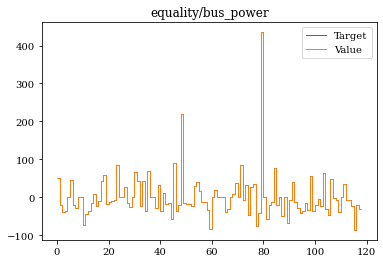

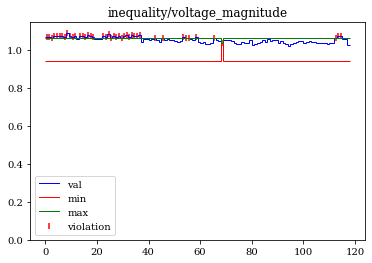

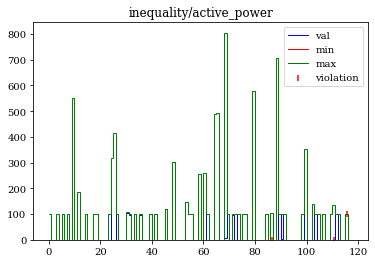

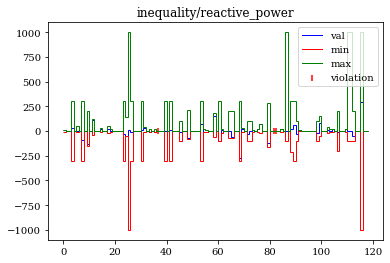

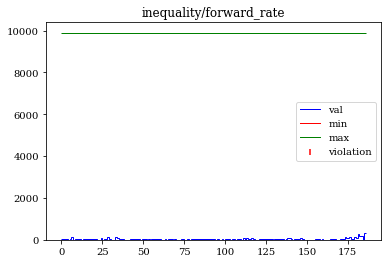

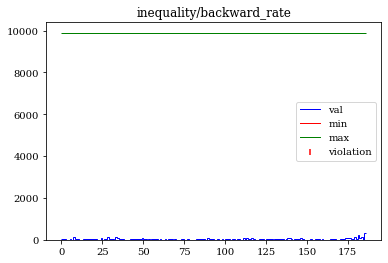

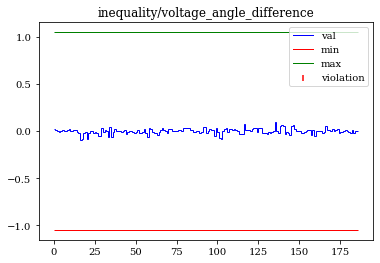

In [10]:
import opf.plot

dataset = list(dm.test_dataloader())
barrier.double()
load = dataset[index][0].double() @ barrier.powerflow_parameters.load_matrix
with torch.no_grad():
    variables, _, _, _ = barrier._step_helper(*barrier(load), True)
plots = opf.plot.plot_constraints(variables, barrier.powerflow_parameters)

In [21]:
forward_error = df.iloc[index]["test/inequality/forward_rate/error_max"]
backward_error = df.iloc[index]["test/inequality/backward_rate/error_max"]

increase = 1 + torch.clamp((torch.maximum(variables.Sf.abs(), variables.St.abs()) - barrier.powerflow_parameters.rate_a) / barrier.powerflow_parameters.rate_a, min=0) \
    .squeeze().detach().numpy()
net = barrier.net_wrapper.net
original = net.line.copy()
barrier.net_wrapper.set_load_sparse(variables.Sd.real.squeeze(), variables.Sd.imag.squeeze())

net.line["max_i_ka"] *= increase[:len(net.line)]

bus = torch.as_tensor(barrier.net_wrapper.optimal_ac(False)[0]).double().unsqueeze(0)
_, constraints, cost, _ = barrier._step_helper(
                *barrier.parse_bus(bus),
                variables.Sd,
                project_pandapower=False,
            )
net.line = original

print("IPOPT Original Cost:", df.iloc[index]["acopf/cost"])
print("IPOPT Relaxed Cost:", cost.item())
print("GNN Cost", df.iloc[index]["test/cost"])

IPOPT Original Cost: 842.5876720524286
IPOPT Relaxed Cost: 842.5977928081951
GNN Cost 906.728146662499
